In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1) 

# Prepare to Data

In [4]:
path = 'f1_classification/*'
datas_paths = glob(path)
print(datas_paths)
X = []
labels = []

['f1_classification\\Ferrari', 'f1_classification\\McLaren', 'f1_classification\\Mercedes', 'f1_classification\\RedBull']


In [5]:
def color_imread(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(28,28),cv2.INTER_AREA)
    img = (img/127.5) - 1
    img = img.astype(np.float32)
    return img

In [6]:
for label_path in datas_paths:
    label = label_path.split('\\')[1]
    image_path = glob(label_path+'/*')
    for path in image_path:
        img = color_imread(path)
        X.append(img)
        labels.append(label)                

In [7]:
len(labels) , len(X)

(280, 280)

Converting labels to LabelEncoder

In [8]:
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels[1],labels[79],labels[179],labels[279])

0 1 2 3


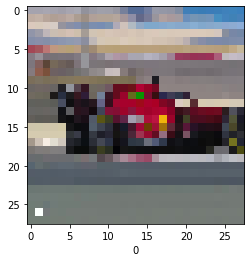

In [9]:
img = (X[0]+1)*127.5
img = np.uint8(img)
plt.imshow(img)
plt.xlabel(labels[0]) # 0 means 'Ferrari'
plt.show()

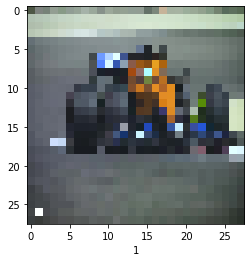

In [10]:
img = (X[79]+1)*127.5
img = np.uint8(img)
plt.imshow(img)
plt.xlabel(labels[79]) # 1 means 'McLaren'
plt.show()

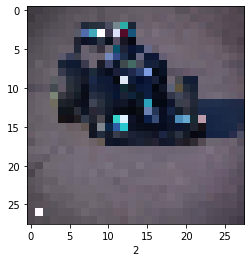

In [11]:
img = (X[170]+1)*127.5
img = np.uint8(img)
plt.imshow(img)
plt.xlabel(labels[170]) # 2 means 'Mercedes'
plt.show()

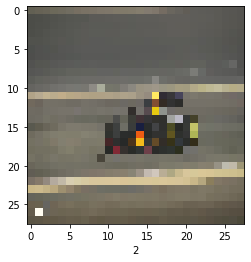

In [12]:
img = (X[279]+1)*127.5
img = np.uint8(img)
plt.imshow(img)
plt.xlabel(labels[179]) # 3 means 'RedBull'
plt.show()

In [13]:
x_train,x_test,y_train,y_test = train_test_split(X,labels,test_size=0.25,random_state=42)

In [14]:
x_train = torch.tensor(x_train)
x_train.shape

C:\Users\ardac\AppData\Local\Temp\ipykernel_15588\2699387513.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  x_train = torch.tensor(x_train)


torch.Size([210, 28, 28, 3])

In [15]:
x_test = torch.tensor(x_test)
x_test.shape

torch.Size([70, 28, 28, 3])

In [16]:
x_train = np.reshape(x_train,(-1,3,28,28))
x_test = np.reshape(x_test,(-1,3,28,28))
x_train.shape , x_test.shape

(torch.Size([210, 3, 28, 28]), torch.Size([70, 3, 28, 28]))

# Build Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5))
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))
        self.conv4 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))
        # Evrişim katmanının boyutları   = (W - K + 2P)
        #                                  ------------ + 1
        #                                       S
        # burada, 
        #       W = Önceki katmanın Yükseklik/Genişlik = 28
        #       K = Filtre Boyutu = 3
        #       P = Piksel ekleme (Padding) = 0
        #       S = Adım Aralığı (Stride) = 1(default)
        #           Eğer piksel ekleme = 0
        #           Çıkış şekli (shape) = ((28 - 3 + 2*0)/1)+1 = 26 
        
        self.max = nn.MaxPool2d(kernel_size=(2,2))
        self.func = nn.ReLU()
        self.fully1 = nn.Linear(in_features=32,out_features=50)
        self.fully2 = nn.Linear(in_features=50,out_features=50)
        self.fully3 = nn.Linear(in_features=50,out_features=100)
        self.fully4 = nn.Linear(in_features=100,out_features=4)
        
    def forward(self,x): # x is our data
        x = self.conv1(x)
        x = self.func(x)
        x = self.max(x)
        x = self.conv2(x)
        x = self.func(x)
        x = self.max(x)
        x = self.conv3(x)
        x = self.func(x)
        x = self.max(x)
        x = self.conv4(x)
        x = self.func(x)
        
        x =x.view(x.shape[1],-1)

        x = self.fully1(x)
        x = self.func(x)
        x = self.fully2(x)
        x = self.func(x) 
        x = self.fully3(x)
        x = self.func(x)
        x = self.fully4(x)

        return x       
        

# Model Training

In [18]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
error = torch.nn.CrossEntropyLoss()
epochs = 150

for epoch in range(epochs):
    
    for _,(image,label) in enumerate(zip(x_train,y_train)):
        optimizer.zero_grad()
        x = torch.linspace(3, 256, 256).float().unsqueeze(-1)
        out = model(image)
        out=torch.squeeze(out)
        label = torch.tensor(label)
        loss = error(out,label)
        loss.backward()
        
        optimizer.step()
        
    print(epoch , loss.item())





0 1.4390302896499634
1 1.427236795425415
2 1.4172147512435913
3 1.4082847833633423
4 1.3991588354110718
5 1.3854705095291138
6 1.3577609062194824
7 1.3088297843933105
8 1.2421225309371948
9 1.1665083169937134
10 1.1007075309753418
11 1.0424151420593262
12 0.9955140948295593
13 0.9602124094963074
14 0.932326078414917
15 0.9106076955795288
16 0.8937235474586487
17 0.8790504336357117
18 0.8645519018173218
19 0.8493396639823914
20 0.8349331021308899
21 0.8216374516487122
22 0.8087289333343506
23 0.794514000415802
24 0.7797613739967346
25 0.762370765209198
26 0.7475982308387756
27 0.7329451441764832
28 0.7180379033088684
29 0.7027878761291504
30 0.6872729063034058
31 0.6717046499252319
32 0.6540654897689819
33 0.6342208385467529
34 0.6163862347602844
35 0.5976475477218628
36 0.58045893907547
37 0.5620426535606384
38 0.5453808307647705
39 0.5273253321647644
40 0.5090771913528442
41 0.49139952659606934
42 0.47477468848228455
43 0.45989376306533813
44 0.44342097640037537
45 0.4287560284137726


# Test Model

In [27]:
type(x_test)

torch.Tensor

In [50]:
def accuracy(x_test,y_test,model):
    num_correct = 0
    model.eval()
    
    with torch.no_grad():
        for _,(image,label) in enumerate (zip(x_test,y_test)):
            predict = model(image)
            predict = predict.numpy()
            pred = predict.argmax()
            if pred == label:
                num_correct+=1
        print('Accuracy: ',float(num_correct/len(x_test)))    
        model.train()
        
            
        

In [51]:
accuracy(x_test,y_test,model)

Accuracy:  0.6
